# risklearning demo

Most, if not all, operational risk capital models assume the existence of stationary frequency and severity distributions (typically Poisson for frequencies, and a subexponential distribution such as lognormal for severities). Yet every quarter (or whenever the model is recalibrated) risk capital goes up almost without fail, either because frequencies increase, severities increase or both.

The assumption of stationary distributions is just one limitation of current approaches to operational risk modeling, but it offers a good inroad for modeling approaches beyond the usual actuarial model typical in operational capital models.

In this notebook, we give a first example of how neural networks can overcome the stationarity assumptions of traditional approaches. The hope is that this is but one of many examples showing a better way to model operational risk.

Note: What follows if very much a work in progress . . .



In [4]:
import risklearning.learning_frequency as rlf
reload(rlf)

<module 'risklearning.learning_frequency' from 'risklearning/learning_frequency.pyc'>

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

import ggplot as gg
%matplotlib inline

## Set up frequency distribution to generate samples

In [7]:
tenors_horizon = 365 # (Time) tenors (e.g. 1 day) per model horizon (e.g. 1 year)

h_start = 5.0 # How many model horizons of past data to train
h_end = 1.0 #How many model horizons of past data to test / validate

# Present is tenor 0, and boundary between training and testing data sets
t_start = -int(math.floor(h_start*tenors_horizon))
t_end = int(math.floor(h_end*tenors_horizon))


#% Generate Poisson-distributed events
lambda_init = 1 # intensity over tenor (e.g. day)
lambda_final = 4 # intensity over tenor (e.g. day)
n_tenors = t_end - t_start
lambda_ts = np.linspace(lambda_init, lambda_final, num=n_tenors)
freq_rv = stats.poisson
counts = rlf.sim_counts(lambda_ts, freq_rv)

# Build df around counts, level 1 and 2 categorization of Operational Risk events
l1s = ['Execution Delivery and Process Management']*n_tenors
l2s = ['Transaction Capture, Execution and Maintenance']*n_tenors
tenors = list(xrange(t_start, t_end))

counts_sim_df = pd.DataFrame({'t': tenors,
                              'OR Category L1': l1s, 'OR Category L2': l2s,
                              'counts': counts})


In [8]:
                    
#%% Do MLE (simple average for Poisson process
n_tenors_train = -t_start
n_tenors_test = t_end

counts_train = (counts_sim_df[counts_sim_df.t < 0]).groupby('OR Category L2').sum()
counts_test =  (counts_sim_df[counts_sim_df.t >= 0]).groupby('OR Category L2').sum()


## MLE for training data

For the Poisson distribution, the MLE of the intensity (here lambda) is just the average of the counts per model horizon. In practice, OpRisk models sometimes take a weighted average, with the weight linearly decreasing over a period of years (see e.g. "LDA at Work" by Aue and Kalkbrener).

In [9]:
lambdas_train = counts_train['counts']/n_tenors_train
lambdas_test = counts_train['counts']/n_tenors_test

bin_tops = [1,2,3,4,5,6,7,8,9,10,15,101]
# Recall that digitize (used later) defines bins by lower <= x < upper
count_tops =[count - 1 for count in bin_tops]

# Calculate bin probabilities from MLE poisson
poi_mle = stats.poisson(lambdas_train)
poi_bins = rlf.bin_probs(poi_mle, bin_tops)

mle_probs = pd.DataFrame({'Count Top': count_tops, 'Probs': poi_bins})
#mle_probs = pd.DataFrame(poi_bins, index = [t-1 for t in bin_tops], columns = ['Prob'])

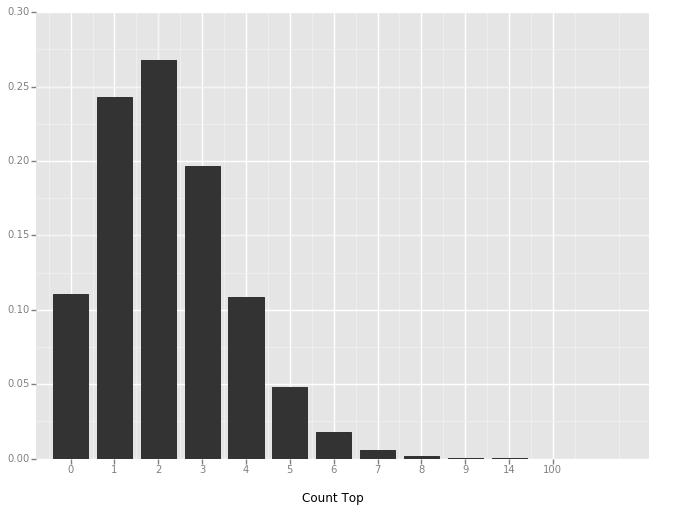

<ggplot: (8730958589049)>


In [23]:
mle_probs_vals = list(mle_probs.Probs)
# Visualize pdf (w.r.t. bins)
print gg.ggplot(mle_probs, gg.aes(x='Count Top',weight='Probs')) \
    + gg.geom_bar()


## Prep simulated losses for neural network

For example

* Use one-hot-encoding for L1 and L2 categories (this will make more sense once we look at multiple dependent categories)
* Bin count data
* Normalize tenors (i.e. scale so that first tenor maps to -1 with 0 preserved)
* Export as numpy arrays to feed into keras / tensorflow

In [24]:
import warnings
warnings.filterwarnings('ignore') # TODO: improve slicing to avoid warnings

x_train, y_train, x_test, y_test = rlf.prep_count_data(counts_sim_df, bin_tops)


## Set up the network architecture and train

We use keras with TensorFlow backend.

Note: there has been no real attempt yet to optimize metaparameters.

In [25]:
from keras.optimizers import SGD
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

rl_net = rlf.rl_train_net(x_train, y_train, x_test, y_test, [150], \
                    n_epoch = 200)


352/365 [===========================>..] - ETA: 0s

## Neural network frequency distribution

If the neural network has learned anything, we will see that the probility distribution shifts over time to higher buckets.

In [28]:
proba = rl_net['probs_nn']

In [30]:
nn_probs = pd.DataFrame(proba, index = range(0,t_end), columns = [t-1 for t in bin_tops])
# Heads (i.e. starting from present)
nn_probs.head()

,0,1,2,3,4,5,6,7,8,9,14,100
0,0.037629,0.157718,0.241357,0.151112,0.174756,0.129090,0.071732,0.021031,0.007957,0.004856,0.002723,0.000039
1,0.037605,0.157678,0.241381,0.151059,0.174754,0.129124,0.071781,0.021033,0.007962,0.004859,0.002726,0.000039
2,0.037581,0.157637,0.241404,0.151005,0.174752,0.129157,0.071830,0.021035,0.007968,0.004862,0.002728,0.000039
3,0.037557,0.157597,0.241428,0.150951,0.174751,0.129191,0.071879,0.021037,0.007974,0.004866,0.002731,0.000039
4,0.037533,0.157557,0.241451,0.150897,0.174749,0.129224,0.071928,0.021039,0.007980,0.004869,0.002734,0.000039


In [31]:
# Tails (i.e. going to end of model horizon of 1 yr)
nn_probs.tail()

,0,1,2,3,4,5,6,7,8,9,14,100
360,0.030155,0.145990,0.250158,0.135467,0.175140,0.138416,0.085165,0.020847,0.009511,0.005640,0.003478,0.000032
361,0.030137,0.145962,0.250189,0.135433,0.175139,0.138438,0.085191,0.020844,0.009514,0.005641,0.003480,0.000032
362,0.030120,0.145933,0.250220,0.135399,0.175138,0.138459,0.085218,0.020841,0.009516,0.005643,0.003481,0.000032
363,0.030102,0.145904,0.250252,0.135365,0.175136,0.138481,0.085245,0.020838,0.009519,0.005644,0.003483,0.000032
364,0.030085,0.145875,0.250283,0.135331,0.175135,0.138502,0.085271,0.020836,0.009521,0.005645,0.003484,0.000032


In [32]:
# And what MLE told us before
mle_probs.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
Count Top,0.000000,1.00000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,14.000000,1.000000e+02
Probs,0.110439,0.24333,0.268063,0.196873,0.108442,0.047786,0.017548,0.005523,0.001521,0.000372,0.000102,1.369019e-08


## Evaluating neural network
The above shows that the neural network learns that counts increase over time, but we want more than just the correct trend, we want to see how far the neural network is from the true distribution, and compare with the MLE fitted distribution.

We do this both numerically (Kullback-Leibler divergance) and graphically.

In [33]:
#% Convert proba from wide to long and append to other probs
# TODO: Missing last tenor in nn proba (already in x_test, y_test)
probs_list = []
kl_mle_list = []
kl_nn_list = []

for t in range(proba.shape[0]):
    nn_probs_t = proba[t]    
    true_bins_t = rlf.bin_probs(stats.poisson(lambda_ts[-t_start+t]), bin_tops)
    probs_t = pd.DataFrame({'Tenor': t, 'Count Top': count_tops, \
                            'Probs True': true_bins_t, \
                            'Probs NN': nn_probs_t, \
                            'Probs MLE': mle_probs_vals}, \
                            index = range(t*len(count_tops), \
                                    t*len(count_tops) + len(count_tops)))
    probs_list.append(probs_t)
    # Calculate KL divergences
    kl_mle_list.append(stats.entropy(true_bins_t, mle_probs_vals))
    kl_nn_list.append(stats.entropy(true_bins_t, nn_probs_t))

probs = pd.concat(probs_list)


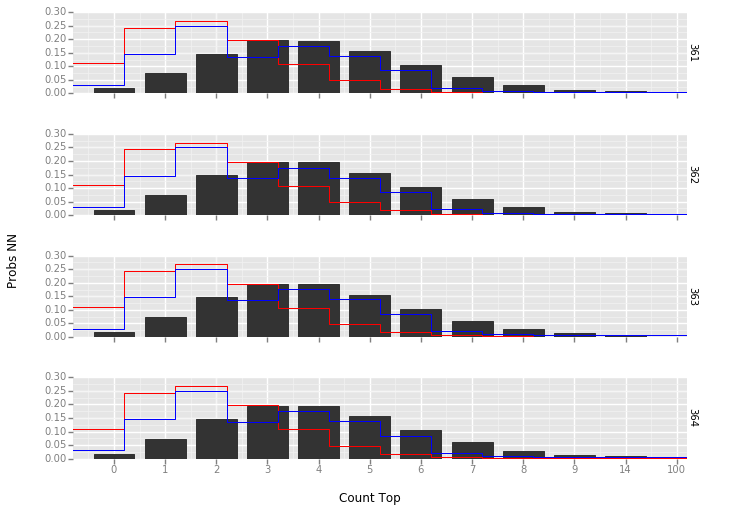

<ggplot: (8730957843845)>

In [34]:
probs_tail = probs[probs.Tenor > 360 ]

gg.ggplot(probs_tail, gg.aes(x='Count Top',weight='Probs True')) \
    + gg.facet_grid('Tenor') \
    + gg.geom_bar() \
    + gg.geom_step(gg.aes(y='Probs MLE', color = 'red')) \
    + gg.geom_step(gg.aes(y='Probs NN', color = 'blue')) \
    + gg.scale_x_continuous(limits = (0,len(count_tops)))



     KL MLE     KL NN  Tenor
0  0.323506  0.040734      0
1  0.324140  0.040865      1
2  0.324775  0.040997      2
3  0.325411  0.041129      3
4  0.326046  0.041261      4
       KL MLE     KL NN  Tenor
360  0.584698  0.108423    360
361  0.585511  0.108676    361
362  0.586324  0.108929    362
363  0.587138  0.109183    363
364  0.587953  0.109437    364


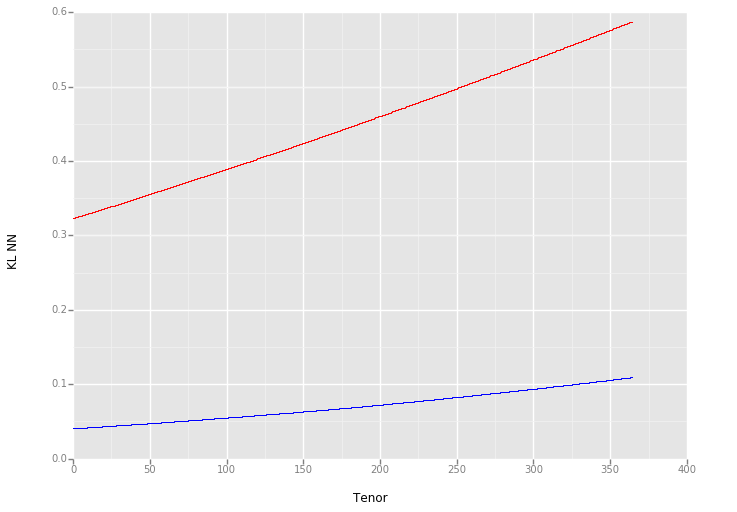

<ggplot: (8730927028757)>

In [62]:
# KL divergences

kl_df = pd.DataFrame({'Tenor': range(0, t_end), \
                      'KL MLE': kl_mle_list, \
                      'KL NN': kl_nn_list})

print kl_df.head()

print kl_df.tail()                      
#%                      
# Plot KL divergences
gg.ggplot(kl_df, gg.aes(x='Tenor')) \
    + gg.geom_step(gg.aes(y='KL MLE', color = 'red')) \
    + gg.geom_step(gg.aes(y='KL NN', color = 'blue'))

In [71]:
# More systematically with NN architecture
# Loop over different architectures, create panel plot
neurons_list = [10, 20,50,100, 200]
depths_list = [1,2,3]

#%%
kl_df_list = []
for depth in depths_list:
    for n_neurons in neurons_list:
        nn_arch = [n_neurons]*depth
        
        rl_net = rlf.rl_train_net(x_train, y_train, x_test, y_test, nn_arch, \
                    n_epoch = 200)
        proba = rl_net['probs_nn']
        probs_kl_dict = rlf.probs_kl(proba, lambda_ts, t_start, t_end, bin_tops, mle_probs_vals)
        probs = probs_kl_dict['Probs']
        kl_df_n = probs_kl_dict['KL df']
    
        kl_df_n['Hidden layers'] = depth
        kl_df_n['Neurons per layer'] = n_neurons
        kl_df_n['Architecture'] = str(depth) + '_layers_of_' + str(n_neurons) \
            + '_neurons'

        kl_df_list.append(kl_df_n)
 #%%
kl_df_hyper = pd.concat(kl_df_list)

288/365 [======================>.......] - ETA: 0s

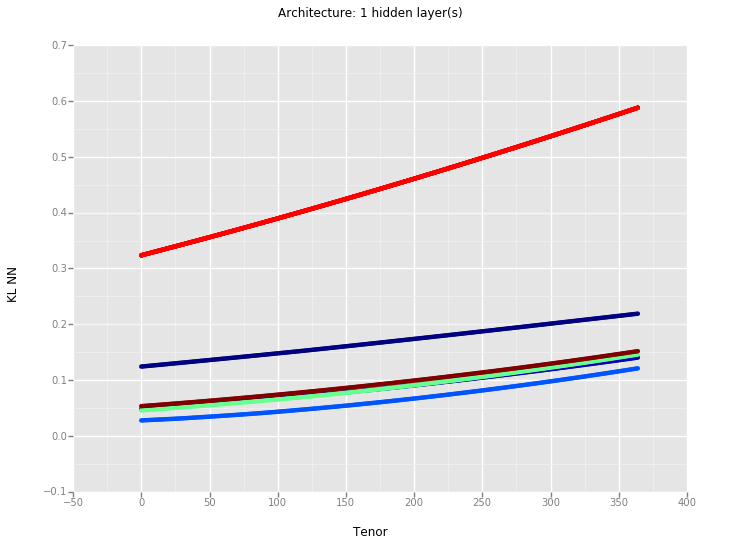

<ggplot: (8730916170053)>


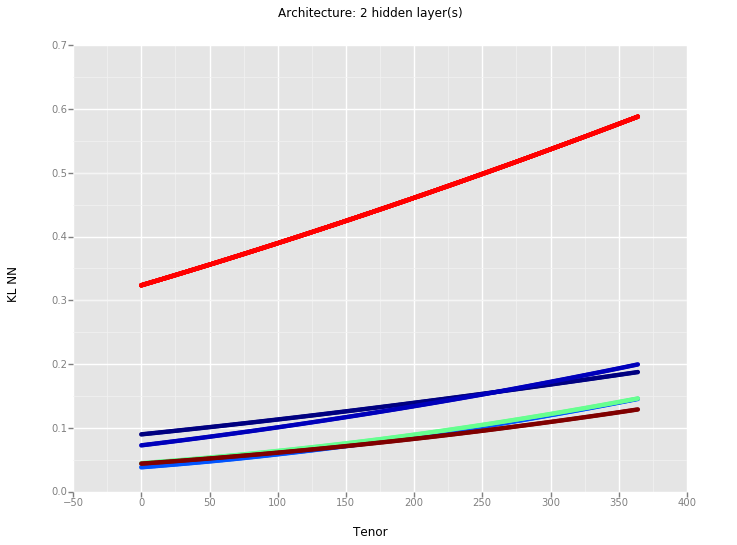

<ggplot: (8730909025553)>


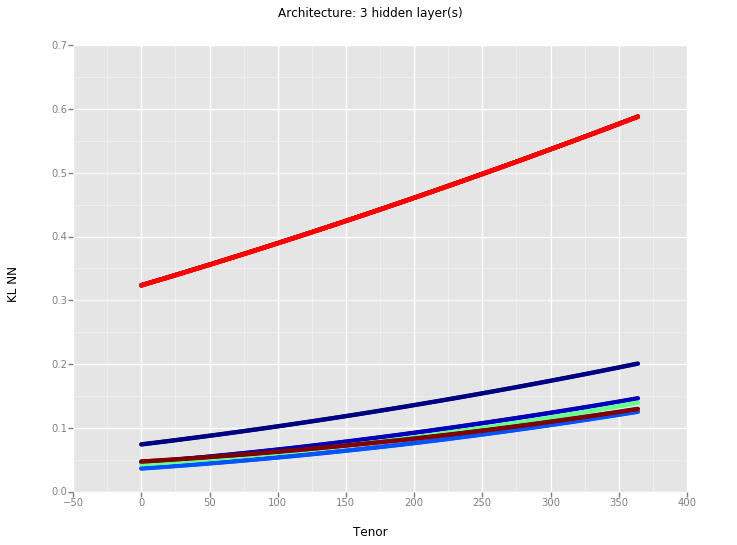

<ggplot: (8730909077305)>


In [72]:
# Plot
# TODO show color legends
for depth in depths_list:
    kl_df_depth = kl_df_hyper[kl_df_hyper['Hidden layers'] == depth]
    print(gg.ggplot(kl_df_depth, gg.aes(x='Tenor')) \
        + gg.geom_point(gg.aes(y='KL MLE', color = 'red')) \
        + gg.geom_point(gg.aes(y='KL NN', color = 'Neurons per layer')) \
        + gg.ggtitle('Architecture: ' + str(depth) + ' hidden layer(s)'))

## Summary and next steps

We can see by the nn_probs data frame that the probability mass of the neural network shifts to the right, as does the underlying Poisson processes, with its intensity starting at 1 events per tenor / day at - 5 yrs and ending at 4 events per tenor / day at +1 yrs.

Next steps:

* Simulate multiple, correlated Poisson processes
* Test non-linear non-stationarities
* Try recurrent neural network
* Try convolution network

